# Introduction

This notebook will dimonstrate the differences between BF16 vs FP8 as well as TP1 vs TP2

# Environment checks

In [1]:
!python3 --version

Python 3.12.3


In [2]:
!nvidia-smi

Tue Nov 11 17:49:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:8D:00.0 Off |                    0 |
| N/A   29C    P0             77W /  700W |       1MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Installing Prerequesists

In [3]:
!apt update -y && apt install pipx -y

Get:1 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease [1581 B]
Get:3 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]      
Get:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]        
Get:5 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]      
Get:6 http://archive.ubuntu.com/ubuntu noble/universe amd64 Packages [19.3 MB] 
Get:7 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [33.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu noble/main amd64 Packages [1808 kB]     
Get:9 http://archive.ubuntu.com/ubuntu noble/restricted amd64 Packages [117 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:11 http://archive.ubuntu.com/ubuntu noble-updates/multiverse amd64 Packages [35.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble-updates/restricted amd64 Packages [2847 kB]
Get

In [4]:
!pipx install vllm==0.11.0 aiperf==0.2.0 lm-eval[api]==0.4.9.1

  installed package vllm 0.11.0, installed using Python 3.12.3
  These apps are now globally available
    - vllm
⚠️  Note: '/root/.local/bin' is not on your PATH environment variable. These
    apps will not be globally accessible until your PATH is updated. Run `pipx
    ensurepath` to automatically add it, or manually modify your PATH in your
    shell's config file (i.e. ~/.bashrc).
done! ✨ 🌟 ✨
  installed package aiperf 0.2.0, installed using Python 3.12.3
  These apps are now globally available
    - aiperf
⚠️  Note: '/root/.local/bin' is not on your PATH environment variable. These
    apps will not be globally accessible until your PATH is updated. Run `pipx
    ensurepath` to automatically add it, or manually modify your PATH in your
    shell's config file (i.e. ~/.bashrc).
done! ✨ 🌟 ✨
  installed package lm-eval 0.4.9.1, installed using Python 3.12.3
  These apps are now globally available
    - lm-eval
    - lm_eval
⚠️  Note: '/root/.local/bin' is not on your PATH environme

In [5]:
import os
os.environ["PATH"] = os.path.expanduser("~/.local/bin") + ":" + os.environ["PATH"]

In [6]:
!git clone https://github.com/NVIDIA/TensorRT-Model-Optimizer.git --depth 1 --branch 0.37.0

Cloning into 'TensorRT-Model-Optimizer'...
remote: Enumerating objects: 921, done.
remote: Counting objects: 100% (921/921), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 921 (delta 134), reused 375 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (921/921), 11.29 MiB | 31.69 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Note: switching to 'df0882a63c39a001a1be384b680166a41259045c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [7]:
!pip3 install \
-r ./TensorRT-Model-Optimizer/examples/llm_ptq/requirements.txt \
-e "./TensorRT-Model-Optimizer[hf]" \
seaborn

Obtaining file:///workspace/main/Yi-34B-fp8-benchmark/TensorRT-Model-Optimizer
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached rouge_score-0.1.2-py3-none-any.whl
  Preparing metadata (setup.py) ... done
  Using cached zstandard-0.25.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached zstandard-0.25.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (5.5 MB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Building editable for nvidia-modelopt (pyproject.toml) ..

# Environment Variables

Feel free to upload your own model or download a different one

In [8]:
os.environ["MODEL_PATH"] = "/workspace/main/Yi-34B"
os.environ["MODEL_NAME"] = "Yi-34B"
os.environ["ROOT_SAVE_PATH"] = "/workspace/main"
os.environ["CONCURRENCY_LIST"] = "1 10 50 100 150"

In [9]:
!hf download 01-ai/Yi-34B --local-dir $MODEL_PATH

Fetching 26 files:   0%|                                 | 0/26 [00:00<?, ?it/s]Downloading 'model-00001-of-00007.safetensors' to '/workspace/main/Yi-34B/.cache/huggingface/download/lqu6seOhawtyORWNwZ2oBr8OUXU=.028c29a21e851f0edc3e2f7375a00720c0fde4eaf1f71cd7fbd8bfc628f5ce52.incomplete'

generation_config.json: 100%|██████████████████| 132/132 [00:00<00:00, 1.61MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/generation_config.json

README.md: 0.00B [00:00, ?B/s]

md5: 100%|█████████████████████████████████████| 519/519 [00:00<00:00, 5.40MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/md5


LICENSE: 11.3kB [00:00, 46.3MB/s]A
Download complete. Moving file to /workspace/main/Yi-34B/LICENSE


config.json: 100%|█████████████████████████████| 605/605 [00:00<00:00, 8.69MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/config.json
README.md: 87.9kB [00:00, 11.0MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/README.md

Yi.svg: 100%|████

# Quantize to FP8

In [10]:
!./TensorRT-Model-Optimizer/examples/llm_ptq/scripts/huggingface_example.sh --model $MODEL_PATH --quant fp8

model: /workspace/main/Yi-34B
quant: fp8
tp (TensorRT-LLM Checkpoint only): 1
pp (TensorRT-LLM Checkpoint only): 1
sparsity: dense
awq_block_size: 
calib: 512
calib_batch_size: 0
auto_quantize_bits: 
input: 
output: 1024
batch: 2
tasks: quant
lm_eval_tasks: mmlu,gsm8k
lm_eval_limit: 
simple_eval_tasks: mmlu
num_sample: 
use_seq_device_map: false
gpu_max_mem_percentage: 
kv_cache_free_gpu_memory_fraction: 0.8
low_memory_mode: 
calib_dataset: 
+ echo '********** unset all SLURM_, PMI_, PMIX_ Variables **********'
********** unset all SLURM_, PMI_, PMIX_ Variables **********
++ env
++ grep '^SLURM_'
++ cut -d= -f 1
++ env
++ grep '^PMI_'
++ cut -d= -f 1
++ env
++ grep '^PMIX_'
++ cut -d= -f 1
+ '[' -z /workspace/main/Yi-34B ']'
+ '[' dense = dense ']'
+ ENABLE_SPARSITY=false
+ case $SPARSITY_FMT in
+ IFS=,
+ for qformat in $QFORMAT
+ case $qformat in
+ IFS=' '
+++ readlink -f ./TensorRT-Model-Optimizer/examples/llm_ptq/scripts/huggingface_example.sh
++ dirname /workspace/main/Yi-34B-fp8-b

# Serve vLLM for FP8-TP1

In [11]:
!touch /tmp/vllm.log

In [12]:
!pkill vllm

In [13]:
!sleep 3

In [14]:
%%bash --bg

vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp1 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [15]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 18:06:40 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=5545) INFO 11-11 18:06:44 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=5545) INFO 11-11 18:06:44 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp1'], 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=5545) INFO 11-11 18:06:50 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=5545) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=5545) INFO 11-11 18:06:50 [model.py:1510] Using max model len 4096
(APIServer pid=5545) INFO 11-11 18:06:50 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer pid=5545) INFO 11-11 18:06:50 [arg

In [16]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:08:28 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP1

In [17]:
import os

os.environ["AIPERF_COMMAND"] = "--ui-type simple --tokenizer {MODEL_PATH} \
--url 127.0.0.1:8000 --streaming --endpoint-type completions \
--output-tokens-mean 256 --output-tokens-stddev 0 \
--synthetic-input-tokens-mean 256 --synthetic-input-tokens-stddev 0 \
--benchmark-duration 20 --extra-inputs ignore_eos:true".format(MODEL_PATH=os.environ["MODEL_PATH"])

In [18]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp1 --concurrency $c; \
done

18:12:19.746315 INFO     Starting AIPerf System                 ]8;id=802009;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=704786;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:12:20.611817 INFO     Registered Dataset Manager     ]8;id=751928;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py\system_controller.py]8;;\:]8;id=158642;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py#291\291]8;;\
                         (id:                                                   
                         'dataset_manager_dc31a58c')                            
18:12:20.615383 INFO     Registered Worker Manager (id: ]8;id=357926;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_c

In [19]:
!ls artifacts

Yi-34B-fp8-tp1-openai-completions-concurrency1
Yi-34B-fp8-tp1-openai-completions-concurrency10
Yi-34B-fp8-tp1-openai-completions-concurrency100
Yi-34B-fp8-tp1-openai-completions-concurrency150
Yi-34B-fp8-tp1-openai-completions-concurrency50


In [20]:
!lm-eval --model local-completions --tasks mmlu_high_school_world_history \
--model_args model=${MODEL_NAME}-fp8-tp1,tokenizer=${MODEL_PATH},base_url=http://127.0.0.1:8000/v1/completions,num_concurrent=16,max_retries=3,tokenized_requests=False \
--output_path ./lm-eval/${MODEL_NAME}-fp8.json

2025-11-11:18:15:13 INFO     [__main__:446] Selected Tasks: ['mmlu_high_school_world_history']
2025-11-11:18:15:13 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-11-11:18:15:13 INFO     [evaluator:240] Initializing local-completions model, with arguments: {'model': 'Yi-34B-fp8-tp1', 'tokenizer': '/workspace/main/Yi-34B', 'base_url':
        'http://127.0.0.1:8000/v1/completions', 'num_concurrent': 16, 'max_retries': 3, 'tokenized_requests': False}
2025-11-11:18:15:13 INFO     [models.api_models:170] Using max length 2048 - 1
2025-11-11:18:15:13 INFO     [models.api_models:189] Using tokenizer huggingface
README.md: 53.2kB [00:00, 150MB/s]
dataset_infos.json: 138kB [00:00, 300MB/s]
high_school_world_history/test-00000-of-(…): 100%|█| 202k/202k [00:00<00:00, 304
high_school_world_history/validation-000(…): 100%|█| 38.5k/38.5k [00:00<00:00, 1
high_school_world_history/dev-00000-o

# Serve vLLM for BF16-TP1

In [21]:
!pkill vllm

In [22]:
!sleep 5

In [23]:
%%bash --bg

~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp1 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [24]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 18:16:34 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=12880) INFO 11-11 18:16:37 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=12880) INFO 11-11 18:16:37 [utils.py:233] non-default args: {'model_tag': '/workspace/main/Yi-34B', 'model': '/workspace/main/Yi-34B', 'served_model_name': ['Yi-34B-bf16-tp1'], 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=12880) INFO 11-11 18:16:37 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=12880) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=12880) INFO 11-11 18:16:37 [model.py:1510] Using max model len 4096
(APIServer pid=12880) INFO 11-11 18:16:38 [arg_utils.py:1293] Defaulting to mp-based distributed executor backend for async scheduling.
(APIServer pid=12880) INFO 11-11 18:16:38 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 11-11 18:16:41 [__init__.py:216] Automatically detected platform 

In [25]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:18:02 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP1

In [26]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp1 --concurrency $c; \
done

18:18:04.333539 INFO     Starting AIPerf System                 ]8;id=309723;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=787783;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:18:05.191286 INFO     Registered Dataset Manager     ]8;id=950530;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py\system_controller.py]8;;\:]8;id=860517;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py#291\291]8;;\
                         (id:                                                   
                         'dataset_manager_6254695f')                            
18:18:05.193154 INFO     Record metrics    ]8;id=610339;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_re

In [27]:
!lm-eval --model local-completions --tasks mmlu_high_school_world_history \
--model_args model=${MODEL_NAME}-bf16-tp1,tokenizer=${MODEL_PATH},base_url=http://127.0.0.1:8000/v1/completions,num_concurrent=16,max_retries=3,tokenized_requests=False \
--output_path ./lm-eval/${MODEL_NAME}.json

2025-11-11:18:20:20 INFO     [__main__:446] Selected Tasks: ['mmlu_high_school_world_history']
2025-11-11:18:20:20 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-11-11:18:20:20 INFO     [evaluator:240] Initializing local-completions model, with arguments: {'model': 'Yi-34B-bf16-tp1', 'tokenizer': '/workspace/main/Yi-34B', 'base_url':
        'http://127.0.0.1:8000/v1/completions', 'num_concurrent': 16, 'max_retries': 3, 'tokenized_requests': False}
2025-11-11:18:20:20 INFO     [models.api_models:170] Using max length 2048 - 1
2025-11-11:18:20:20 INFO     [models.api_models:189] Using tokenizer huggingface
2025-11-11:18:20:22 INFO     [api.task:434] Building contexts for mmlu_high_school_world_history on rank 0...
100%|███████████████████████████████████████| 237/237 [00:00<00:00, 1115.99it/s]
2025-11-11:18:20:23 INFO     [evaluator:574] Running loglikelihood requests
Requestin

# Compare FP8 and BF16 on MMLU Accuracy

In [28]:
!cat ./lm-eval/* | jq '.model_name, .results'

"Yi-34B-fp8-tp1"
{
  "mmlu_high_school_world_history": {
    "alias": "high_school_world_history",
    "acc,none": 0.8945147679324894,
    "acc_stderr,none": 0.019995560723758587
  }
}
"Yi-34B-bf16-tp1"
{
  "mmlu_high_school_world_history": {
    "alias": "high_school_world_history",
    "acc,none": 0.8860759493670886,
    "acc_stderr,none": 0.020681745135884527
  }
}


# Serve vLLM for FP8-TP2

In [29]:
!pkill vllm

In [30]:
!sleep 5

In [31]:
%%bash --bg
~/.local/bin/vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp2 \
    --tensor-parallel-size 2 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [32]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 18:21:17 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=20007) INFO 11-11 18:21:21 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=20007) INFO 11-11 18:21:21 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp2'], 'tensor_parallel_size': 2, 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=20007) INFO 11-11 18:21:21 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=20007) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=20007) INFO 11-11 18:21:21 [model.py:1510] Using max model len 4096
(APIServer pid=20007) INFO 11-11 18:21:21 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer p

In [33]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:23:00 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP2

In [34]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp2 --concurrency $c; \
done

18:23:02.228787 INFO     Starting AIPerf System                 ]8;id=721546;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=392504;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:23:03.066280 INFO     Record metrics    ]8;id=373894;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=376083;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         fp8-tp2-openai-co                                      
                         mpletions-concurr         

# Serve vLLM for BF16-TP2

In [35]:
!pkill vllm

In [36]:
!sleep 5

In [37]:
%%bash --bg

~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp2 \
    --tensor-parallel-size 2 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [38]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 18:25:14 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=27319) INFO 11-11 18:25:17 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=27319) INFO 11-11 18:25:17 [utils.py:233] non-default args: {'model_tag': '/workspace/main/Yi-34B', 'model': '/workspace/main/Yi-34B', 'served_model_name': ['Yi-34B-bf16-tp2'], 'tensor_parallel_size': 2, 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=27319) INFO 11-11 18:25:17 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=27319) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=27319) INFO 11-11 18:25:17 [model.py:1510] Using max model len 4096
(APIServer pid=27319) INFO 11-11 18:25:17 [arg_utils.py:1293] Defaulting to mp-based distributed executor backend for async scheduling.
(APIServer pid=27319) INFO 11-11 18:25:17 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 11-11 18:25:20 [__init__.py:216] Autom

In [39]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:26:41 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP2

In [40]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp2 --concurrency $c; \
done

18:26:43.340298 INFO     Starting AIPerf System                 ]8;id=417811;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=19625;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:26:44.199438 INFO     Record metrics    ]8;id=120435;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=464230;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         bf16-tp2-openai-c                                      
                         ompletions-concur          

# Serve vLLM for FP8-TP8

In [41]:
!pkill vllm

In [42]:
!sleep 5

In [43]:
%%bash --bg
~/.local/bin/vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp8 \
    --tensor-parallel-size 8 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [44]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 18:28:53 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=34548) INFO 11-11 18:28:56 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=34548) INFO 11-11 18:28:56 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp8'], 'tensor_parallel_size': 8, 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=34548) INFO 11-11 18:28:56 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=34548) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=34548) INFO 11-11 18:28:56 [model.py:1510] Using max model len 4096
(APIServer pid=34548) INFO 11-11 18:28:56 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer p

In [45]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:30:58 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP8

In [46]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp8 --concurrency $c; \
done

18:30:59.918567 INFO     Starting AIPerf System                 ]8;id=24052;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=458586;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:31:00.801563 INFO     Registered Dataset Manager     ]8;id=413536;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py\system_controller.py]8;;\:]8;id=776630;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py#291\291]8;;\
                         (id:                                                   
                         'dataset_manager_070d0b45')                            
18:31:00.803404 INFO     Record metrics    ]8;id=486552;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_res

# Serve vLLM for BF16-TP8

In [47]:
!pkill vllm

In [48]:
!sleep 5

In [49]:
%%bash --bg
~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp8 \
    --tensor-parallel-size 8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [50]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

(Worker_TP3 pid=34828) INFO 11-11 18:33:00 [multiproc_executor.py:599] WorkerProc shutting down.
(Worker_TP4 pid=34829) INFO 11-11 18:33:00 [multiproc_executor.py:599] WorkerProc shutting down.
(Worker_TP5 pid=34830) INFO 11-11 18:33:00 [multiproc_executor.py:558] Parent process exited, terminating worker
(Worker_TP5 pid=34830) INFO 11-11 18:33:00 [multiproc_executor.py:599] WorkerProc shutting down.
(Worker_TP6 pid=34831) INFO 11-11 18:33:00 [multiproc_executor.py:558] Parent process exited, terminating worker
(Worker_TP6 pid=34831) INFO 11-11 18:33:00 [multiproc_executor.py:599] WorkerProc shutting down.
(Worker_TP7 pid=34832) INFO 11-11 18:33:00 [multiproc_executor.py:558] Parent process exited, terminating worker
(APIServer pid=34548) INFO:     Shutting down
(APIServer pid=34548) INFO:     Waiting for application shutdown.
(APIServer pid=34548) INFO:     Application shutdown complete.
tail: /tmp/vllm.log: file truncated
INFO 11-11 18:33:10 [__init__.py:216] Automatically detected p

In [51]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 18:34:56 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP8

In [52]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp8 --concurrency $c; \
done

18:34:57.345494 INFO     Starting AIPerf System                 ]8;id=115331;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=801386;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
18:34:58.186774 INFO     Registered Dataset Manager     ]8;id=115725;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py\system_controller.py]8;;\:]8;id=22374;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_controller.py#291\291]8;;\
                         (id:                                                   
                         'dataset_manager_d8b69add')                            
18:34:58.190089 INFO     Registered Worker Manager (id: ]8;id=97043;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/controller/system_con

# Plot Benchmarking Data

In [53]:
!ls artifacts

Yi-34B-bf16-tp1-openai-completions-concurrency1
Yi-34B-bf16-tp1-openai-completions-concurrency10
Yi-34B-bf16-tp1-openai-completions-concurrency100
Yi-34B-bf16-tp1-openai-completions-concurrency150
Yi-34B-bf16-tp1-openai-completions-concurrency50
Yi-34B-bf16-tp2-openai-completions-concurrency1
Yi-34B-bf16-tp2-openai-completions-concurrency10
Yi-34B-bf16-tp2-openai-completions-concurrency100
Yi-34B-bf16-tp2-openai-completions-concurrency150
Yi-34B-bf16-tp2-openai-completions-concurrency50
Yi-34B-bf16-tp8-openai-completions-concurrency1
Yi-34B-bf16-tp8-openai-completions-concurrency10
Yi-34B-bf16-tp8-openai-completions-concurrency100
Yi-34B-bf16-tp8-openai-completions-concurrency150
Yi-34B-bf16-tp8-openai-completions-concurrency50
Yi-34B-fp8-tp1-openai-completions-concurrency1
Yi-34B-fp8-tp1-openai-completions-concurrency10
Yi-34B-fp8-tp1-openai-completions-concurrency100
Yi-34B-fp8-tp1-openai-completions-concurrency150
Yi-34B-fp8-tp1-openai-completions-concurrency50
Yi-34B-fp8-tp2-openai

In [54]:
import pandas as pd 
import seaborn as sns

In [55]:
def normalize_df_benchmark(df):
    df.melt(id_vars=['Metric'], var_name='stat', value_name='value').pivot_table(index=None, columns=['Metric', 'stat'], values='value', aggfunc='first')
    normalized = (
        df.melt(id_vars=['Metric'], var_name='stat', value_name='value')
          .pivot_table(index=None, columns=['Metric', 'stat'], values='value', aggfunc='first')
    )
    
    # Flatten the MultiIndex into single-level columns like Metric_stat
    normalized.columns = [f"{metric.strip().replace(' ', '_')}_{stat}" for metric, stat in normalized.columns]
    normalized = normalized.reset_index(drop=True)
    normalized = normalized.apply(pd.to_numeric, errors='coerce')
    
    return normalized

In [56]:
profiles_dirs = sorted(os.listdir("artifacts"))
df_benchmark_list = []
for pdir in profiles_dirs:
    model_name, concurrency = pdir.split("-openai-completions-concurrency")
    concurrency = int(concurrency)
    _, dtype, tensor_parallelism = model_name.rsplit("-", 2)
    tensor_parallelism = int(tensor_parallelism.strip("tp"))

    df_benchmark_pdir = pd.read_csv("artifacts/" + pdir +"/profile_export_aiperf.csv", on_bad_lines='skip')
    df_benchmark_pdir = normalize_df_benchmark(df_benchmark_pdir)
    df_benchmark_pdir = df_benchmark_pdir.assign(model=model_name, dtype=dtype, tensor_parallelism=tensor_parallelism)

    throughput_columns = "Output_Token_Throughput_(tokens/sec)_avg"
    df_benchmark_pdir[throughput_columns] = df_benchmark_pdir[throughput_columns] / df_benchmark_pdir["tensor_parallelism"]
    
    df_benchmark_list.append(df_benchmark_pdir)

df_benchmark = pd.concat(df_benchmark_list, ignore_index=True)

# Renaming columns
df_benchmark["TTFT (ms)"] = df_benchmark["Time_to_First_Token_(ms)_avg"]
df_benchmark["ITL (ms)"] = df_benchmark["Inter_Token_Latency_(ms)_avg"]
df_benchmark["TPS per User"] = df_benchmark["Output_Token_Throughput_Per_User_(tokens/sec/user)_avg"]
df_benchmark["TPS per GPU"] = df_benchmark["Output_Token_Throughput_(tokens/sec)_avg"]

In [57]:
list(df_benchmark.columns)

['Benchmark_Duration_(sec)_avg',
 'Input_Sequence_Length_(tokens)_avg',
 'Input_Sequence_Length_(tokens)_max',
 'Input_Sequence_Length_(tokens)_min',
 'Input_Sequence_Length_(tokens)_p1',
 'Input_Sequence_Length_(tokens)_p10',
 'Input_Sequence_Length_(tokens)_p25',
 'Input_Sequence_Length_(tokens)_p5',
 'Input_Sequence_Length_(tokens)_p50',
 'Input_Sequence_Length_(tokens)_p75',
 'Input_Sequence_Length_(tokens)_p90',
 'Input_Sequence_Length_(tokens)_p95',
 'Input_Sequence_Length_(tokens)_p99',
 'Input_Sequence_Length_(tokens)_std',
 'Inter_Chunk_Latency_(ms)_avg',
 'Inter_Chunk_Latency_(ms)_max',
 'Inter_Chunk_Latency_(ms)_min',
 'Inter_Chunk_Latency_(ms)_p1',
 'Inter_Chunk_Latency_(ms)_p10',
 'Inter_Chunk_Latency_(ms)_p25',
 'Inter_Chunk_Latency_(ms)_p5',
 'Inter_Chunk_Latency_(ms)_p50',
 'Inter_Chunk_Latency_(ms)_p75',
 'Inter_Chunk_Latency_(ms)_p90',
 'Inter_Chunk_Latency_(ms)_p95',
 'Inter_Chunk_Latency_(ms)_p99',
 'Inter_Chunk_Latency_(ms)_std',
 'Inter_Token_Latency_(ms)_avg',
 '

<Axes: xlabel='TTFT (ms)', ylabel='TPS per GPU'>

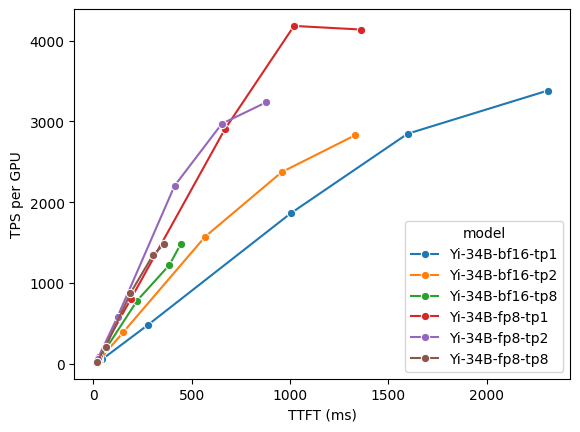

In [58]:
sns.lineplot(data=df_benchmark, x="TTFT (ms)", y="TPS per GPU", hue="model", marker="o")

<Axes: xlabel='ITL (ms)', ylabel='TPS per GPU'>

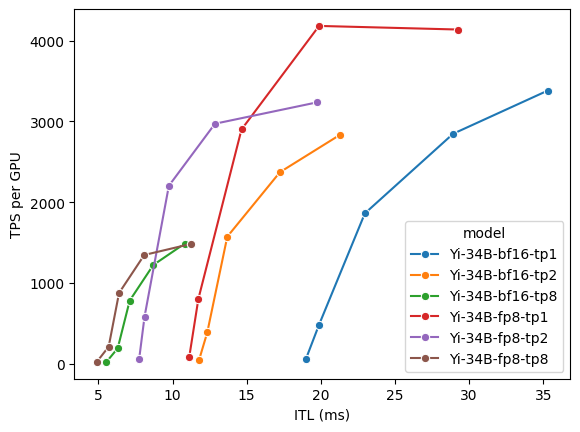

In [59]:
sns.lineplot(data=df_benchmark, x="ITL (ms)", y="TPS per GPU", hue="model", marker="o")

<Axes: xlabel='TPS per User', ylabel='TPS per GPU'>

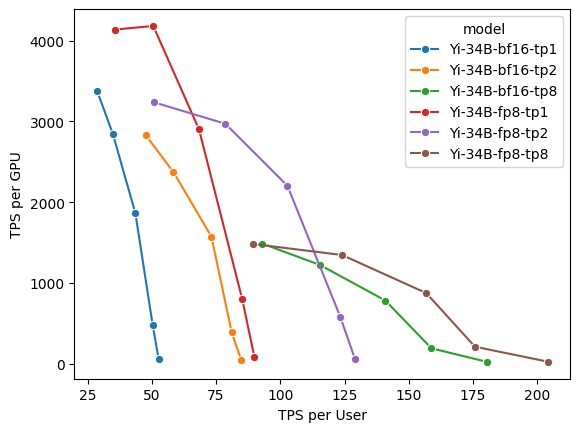

In [60]:
sns.lineplot(data=df_benchmark, x="TPS per User", y="TPS per GPU", hue="model", marker="o")